In [1]:
import torch
import torch.nn as nn
import random

import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor

from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as T

import torchvision.models.detection as detection
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.transform import GeneralizedRCNNTransform

from torchvision import models
from torchsummary import summary


from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont, ImageOps, ImageStat
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import PIL


import utils

import json

In [2]:
base_path = "D:/Programmation/IA/datas/sarscope/SARscope/"
print(os.path.exists(base_path))
os.listdir(base_path)

True


['annotations_test.coco.json',
 'annotations_train.coco.json',
 'annotations_valid.coco.json',
 'README.roboflow.txt',
 'test',
 'train',
 'valid']

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [4]:
def load_annotations(annotation_path):
    with open(annotation_path, "r") as f:
        annotations = json.load(f)
    return annotations

In [5]:
def draw_bounding_boxes(image, bboxes):
    draw = ImageDraw.Draw(image)
    font_size = int(min(image.size) * 0.02)  # Adjust font size based on image size

    for bbox, category_id in bboxes:
        x, y, w, h = bbox
        x1, y1, x2, y2 = x, y, x + w, y + h
        # color = category_colors.get(category_id, 'white')  # Default to white if category_id is unknown
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        draw.text((x1, y1 - font_size), str(category_id), fill="red")
    return image


def visualize_samples(image_dir, annotation_path, num_samples=5):
    annotations = load_annotations(annotation_path)
    images_info = annotations["images"]
    bboxes_infos = annotations["annotations"]

    image_with_bboxes = {}
    for bbox in bboxes_infos:
        image_id = bbox["image_id"]
        if image_id not in image_with_bboxes:
            image_with_bboxes[image_id] = []
        image_with_bboxes[image_id].append((bbox['bbox'], bbox['category_id']))

    random.shuffle(images_info)

    plt.figure(figsize=(15, num_samples * 5))
    sample_count = 0
    for image_info in images_info:
        if sample_count >= num_samples:
            break

        image_path = os.path.join(image_dir, image_info['file_name'])

        if not os.path.exists(image_path):
            continue

        image = Image.open(image_path)
        image_id = image_info['id']
        if image_id in image_with_bboxes:
            bboxes = image_with_bboxes[image_id]
            image = draw_bounding_boxes(image, bboxes)
        else:
          image = image

        plt.subplot(num_samples, 1, sample_count + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Image ID: {image_id}")
        sample_count += 1

    plt.tight_layout()
    plt.show()

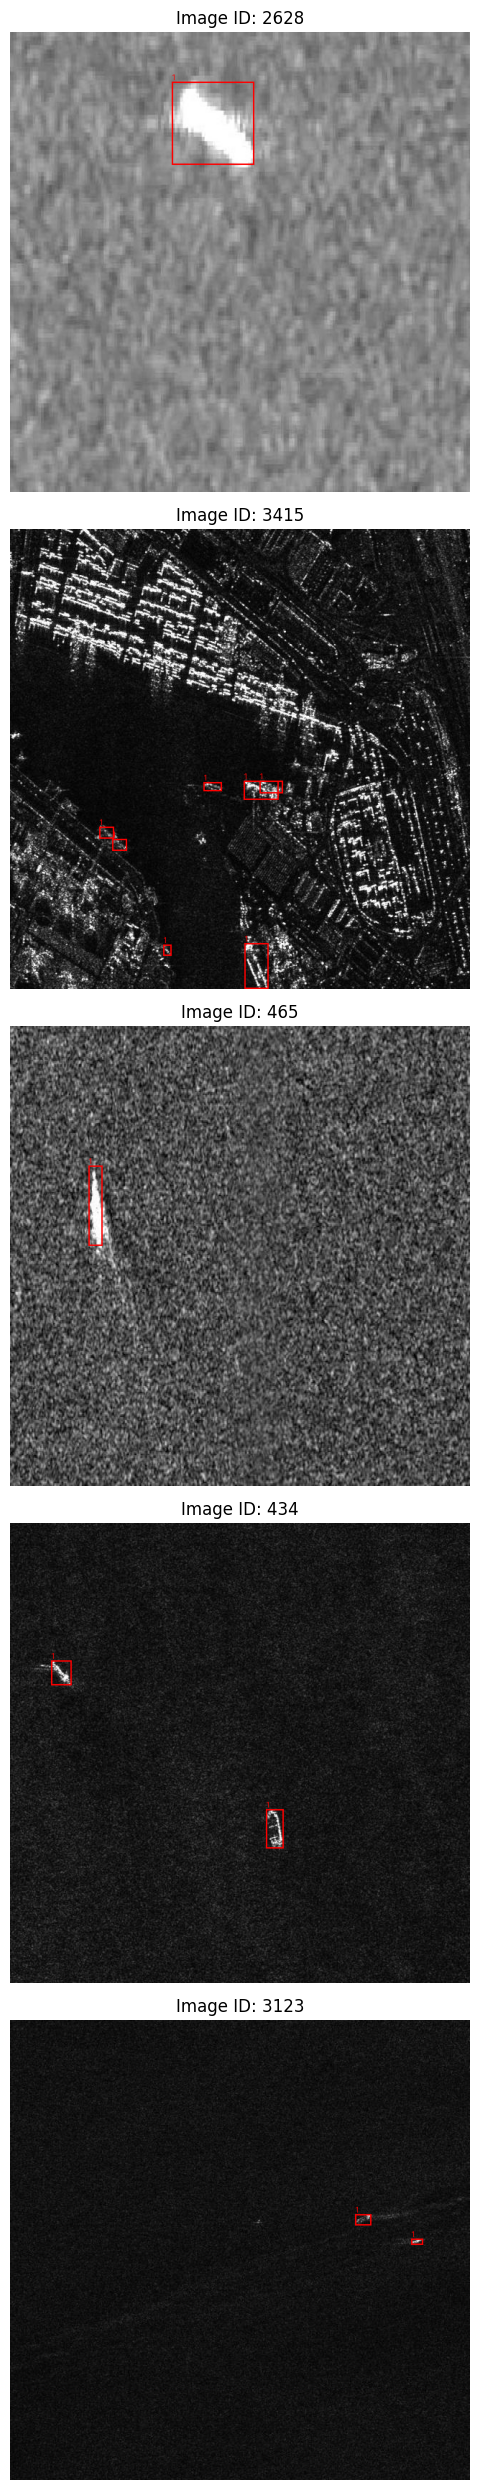

In [6]:
subset = "train"
subset_path = os.path.join(base_path, subset)
visualize_samples(
    image_dir=subset_path,
    annotation_path=os.path.join(base_path, f"annotations_{subset}.coco.json"),
    num_samples=5
)

In [7]:
def collate_fn(batch):
    images, targets = zip(*batch)
    filtered_targets = []
    for target in targets:
        boxes = []
        labels = []
        for ann in target:
            x, y, w, h = ann['bbox']
            if w > 0 and h > 0:
                boxes.append([x, y, x + w, y + h])  # <-- conversion ici
                labels.append(ann['category_id'])
        if boxes:
            filtered_targets.append({
                'boxes': torch.tensor(boxes, dtype=torch.float32),
                'labels': torch.tensor(labels, dtype=torch.int64)
            })
        else:
            # Pour éviter des batches vides (Faster R-CNN n'aime pas ça)
            filtered_targets.append({
                'boxes': torch.zeros((0, 4), dtype=torch.float32),
                'labels': torch.zeros((0,), dtype=torch.int64)
            })
    return images, filtered_targets

In [8]:
train_transforms = T.Compose([
    T.RandomHorizontalFlip(p=0.3),  # Flip horizontal aléatoire
    T.RandomVerticalFlip(p=0.3),    # Flip vertical aléatoire
    T.ToTensor()                    # Conversion en tenseur
])


In [9]:
subset = "train"
json_file = os.path.join(base_path, f"annotations_{subset}.coco.json")
image_dir = os.path.join(base_path, subset)

train_dataset = CocoDetection(root=image_dir, annFile=json_file, transform=train_transforms)

subset = "test"
json_file = os.path.join(base_path, f"annotations_{subset}.coco.json")
image_dir = os.path.join(base_path, subset)

test_dataset = CocoDetection(root=image_dir, annFile=json_file, transform=ToTensor())

subset = "valid"
json_file = os.path.join(base_path, f"annotations_{subset}.coco.json")
image_dir = os.path.join(base_path, subset)

val_dataset = CocoDetection(root=image_dir, annFile=json_file, transform=ToTensor())

print(f"Train: {len(train_dataset)} | Test: {len(test_dataset)} | Val: {len(val_dataset)}")

loading annotations into memory...
Done (t=0.59s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.14s)
creating index...
index created!
Train: 4717 | Test: 672 | Val: 1346


In [10]:
train_data_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
test_data_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=collate_fn)

In [11]:
batch = next(iter(train_data_loader))
images, targets = batch
targets[0]

{'boxes': tensor([[631.,  32., 639.,  72.]]), 'labels': tensor([1])}

In [12]:
def get_model(num_classes):
    model = detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")  # best model with mobilenet_v3_large_fpn 
    
    #Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #Replace pretrained head with new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model


num_classes = 1 + 1 # background + class, ie ship
model = get_model(num_classes).to(device)

In [13]:
def count_parameters_and_layers(model):
    total_params = 0
    trainable_params = 0
    trainable_layers = []

    for name, module in model.named_modules():
        for param in module.parameters(recurse=False):
            total_params += param.numel()
            if param.requires_grad:
                trainable_params += param.numel()
                trainable_layers.append(name)
    return total_params, trainable_params, trainable_layers

# Compter les paramètres et obtenir les noms des couches entraînables
total_params, trainable_params, trainable_layers = count_parameters_and_layers(model)

# Afficher les résultats
print(f"Nombre total de paramètres : {total_params:,}".replace(",", " "))
print(f"Nombre de paramètres entraînables : {trainable_params:,}".replace(",", " "))
print("\nCouches entraînables :")
for layer in trainable_layers:
    print(f" - {layer}")

Nombre total de paramètres : 41 299 161
Nombre de paramètres entraînables : 41 076 761

Couches entraînables :
 - backbone.body.layer2.0.conv1
 - backbone.body.layer2.0.conv2
 - backbone.body.layer2.0.conv3
 - backbone.body.layer2.0.downsample.0
 - backbone.body.layer2.1.conv1
 - backbone.body.layer2.1.conv2
 - backbone.body.layer2.1.conv3
 - backbone.body.layer2.2.conv1
 - backbone.body.layer2.2.conv2
 - backbone.body.layer2.2.conv3
 - backbone.body.layer2.3.conv1
 - backbone.body.layer2.3.conv2
 - backbone.body.layer2.3.conv3
 - backbone.body.layer3.0.conv1
 - backbone.body.layer3.0.conv2
 - backbone.body.layer3.0.conv3
 - backbone.body.layer3.0.downsample.0
 - backbone.body.layer3.1.conv1
 - backbone.body.layer3.1.conv2
 - backbone.body.layer3.1.conv3
 - backbone.body.layer3.2.conv1
 - backbone.body.layer3.2.conv2
 - backbone.body.layer3.2.conv3
 - backbone.body.layer3.3.conv1
 - backbone.body.layer3.3.conv2
 - backbone.body.layer3.3.conv3
 - backbone.body.layer3.4.conv1
 - backbone

In [14]:
num_epochs = 100
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
scaler = torch.cuda.amp.GradScaler()

In [15]:
writer = SummaryWriter(log_dir='runs/sar_detection')

def train_one_epoch(model, data_loader, device, optimizer, print_freq, epoch, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Training Epoch {epoch}:"
    model.to(device)

    with tqdm(data_loader, desc=header) as tq:
        for i, (images, targets) in enumerate(tq):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.cuda.amp.autocast(enabled=scaler is not None):
                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

            loss_value = losses.item()

            optimizer.zero_grad()
            if scaler is not None:
                scaler.scale(losses).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                losses.backward()
                optimizer.step()

            metric_logger.update(loss=losses, **loss_dict)
            metric_logger.update(lr=optimizer.param_groups[0]["lr"])

            # Update tqdm postfix to display loss on the progress bar
            tq.set_postfix(loss=losses.item(), lr=optimizer.param_groups[0]["lr"])

            # Log losses to TensorBoard
            writer.add_scalar('Loss/train', losses.item(), epoch * len(data_loader) + i)
            for k, v in loss_dict.items():
                writer.add_scalar(f'Loss/train_{k}', v.item(), epoch * len(data_loader) + i)

    print(f"Average Loss: {metric_logger.meters['loss'].global_avg:.4f}")
    writer.add_scalar('Loss/avg_train', metric_logger.meters['loss'].global_avg, epoch)

In [58]:
def evaluate(model, data_loader, device, epoch, save_dir):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox")
    # total_iou = 0
    # total_detections = 0
    header = "Validation:"
    total_steps = len(data_loader)
    samples = []

    with torch.no_grad(), tqdm(total=total_steps, desc=header) as progress_bar:
        for i, (images, targets) in enumerate(data_loader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            outputs = model(images)

            # Convert outputs for torchmetrics
            preds = [
                {"boxes": out["boxes"], "scores": out["scores"], "labels": out["labels"]}
                for out in outputs
            ]
            targs = [
                {"boxes": tgt["boxes"], "labels": tgt["labels"]}
                for tgt in targets
            ]

            # Update metric for mAP calculation
            metric.update(preds, targs)

            progress_bar.update(1)

    results = metric.compute()
    print("mAP results:")
    print(results)

    # Log mAP to TensorBoard

    for k, v in results.items():
        if v.numel() == 1:  # Single element tensor
            writer.add_scalar(f'mAP/{k}', v.item(), epoch)
        else:  # Multi-element tensor, log each element separately
            for idx, value in enumerate(v):
                writer.add_scalar(f'mAP/{k}_{idx}', value.item(), epoch)
    return results

In [17]:
save_dir = "checkpoints"
os.makedirs(save_dir, exist_ok=True)

In [18]:
best_map = -float('inf') # Training loop

for epoch in range(num_epochs):
    # Memory Cleanup.
    torch.cuda.empty_cache()
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, train_data_loader, device, optimizer, print_freq=50, epoch=epoch, scaler=scaler)
    # evaluate on the validation dataset
    results = evaluate(model, val_data_loader, device, epoch, save_dir='predictions')

    # Save the model checkpoint if it's the best mAP
    current_map = results['map'].item()
    if current_map > best_map:
        best_map = current_map
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_map': best_map,
            'scaler': scaler.state_dict() if scaler is not None else None
        }, os.path.join(save_dir, f'best_model_checkpoint_epoch_{epoch}.pth'))
        best_epoch_model = epoch
        print(f"\tModel saved at {best_epoch_model}")


print("That's it!")
writer.close()

NameError: name 'gc' is not defined

In [19]:
checkpoint_path = os.path.join(save_dir, f"best_model_checkpoint_epoch_{64}.pth")
print(f"Loaded {checkpoint_path}")
# Function to load the trained model
def load_model(checkpoint_path, device):
    model = get_model(2)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

model = load_model(checkpoint_path, device)

Loaded checkpoints\best_model_checkpoint_epoch_64.pth


In [20]:
classes_to_idx = {
    1: "ship",
}

In [21]:
def show_image_with_boxes(img, targets, ax):
    """Plot an image with its bounding boxes on an axis object."""
    # Convert tensor image to PIL for display if needed
    if isinstance(img, torch.Tensor):
        img = to_pil_image(img)
    ax.imshow(img)

    # Check and plot each bounding box with class-specific color
    if 'boxes' in targets and 'labels' in targets and 'scores' in targets:
        boxes = targets['boxes'].cpu().numpy()
        labels = targets['labels'].cpu().numpy()
        scores = targets['scores'].cpu().numpy()
        for bbox, label, score in zip(boxes, labels, scores):
            if score >= 0.5:  # Only show boxes with confidence score >= 0.5
                w = bbox[2] - bbox[0]
                h = bbox[3] - bbox[1]
                rect = patches.Rectangle((bbox[0], bbox[1]), w, h, linewidth=2, edgecolor="red", facecolor='none')
                ax.add_patch(rect)
                ax.text(bbox[0], bbox[1], f'{classes_to_idx[label]}', color='red', fontsize=8, bbox=dict(facecolor="red", alpha=0.5))

def visualize_samples(images, outputs, num_samples=10):
    """Visualize a specified number of samples from a DataLoader in a single column."""
    num_rows = num_samples  # All samples in a single column
    num_cols = 1
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 25 * num_rows // 4))  # Adjust height based on rows

    for idx, (img, output) in enumerate(zip(images, outputs)):
        if idx >= num_samples:
            break  # Stop after displaying the desired number of samples

        show_image_with_boxes(img.cpu(), output, axs[idx])
        axs[idx].axis('off')  # Turn off axis for cleaner look

    plt.tight_layout()
    plt.show()

In [22]:
annotations_test = load_annotations(os.path.join(base_path, "annotations_test.coco.json"))

In [23]:
outputs = []
real_images = []
with tqdm(test_data_loader, desc="Test dataloader inference") as tq:
    for i, (images, targets) in enumerate(tq):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in target.items()} for target in targets]
    
        with torch.no_grad():
            output = model(images)
    
        outputs.append(output)
        real_images.append(images)

Test dataloader inference: 100%|███████████████████████████████████████████████████████| 84/84 [00:42<00:00,  1.98it/s]


In [24]:
true_bboxes = []
for i, img_info in enumerate(annotations_test['images']):
    real_bboxes = [ann['bbox'] for ann in annotations_test['annotations'] if ann['image_id'] == img_info['id']]
    true_bboxes.append(real_bboxes)
true_bboxes = [true_bboxes[i:i + 8] for i in range(0, len(true_bboxes), 8)]

In [53]:
len(true_bboxes), len(outputs), len(real_images)

(84, 84, 84)

In [57]:
metric = MeanAveragePrecision(iou_type="bbox")

with torch.no_grad(), tqdm(total=len(test_data_loader), desc="Computing metric") as progress_bar:
    for i, (images, targets) in enumerate(test_data_loader):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs_test = model(images)

        # Convert outputs for torchmetrics
        preds = [
            {"boxes": out["boxes"], "scores": out["scores"], "labels": out["labels"]}
            for out in outputs_test
        ]
        targs = [
            {"boxes": tgt["boxes"], "labels": tgt["labels"]}
            for tgt in targets
        ]

        # Update metric for mAP calculation
        metric.update(preds, targs)

        progress_bar.update(1)

results = metric.compute()


Computing metric: 100%|████████████████████████████████████████████████████████████████| 84/84 [00:47<00:00,  1.78it/s]


In [60]:
for k, v in results.items():
    print(f"{k}: {v.item()}")

map: 0.5436151623725891
map_50: 0.843625545501709
map_75: 0.6185094714164734
map_small: 0.49138033390045166
map_medium: 0.6922172904014587
map_large: 0.6687196493148804
mar_1: 0.25759682059288025
mar_10: 0.562661349773407
mar_100: 0.6185203790664673
mar_small: 0.5695593953132629
mar_medium: 0.7633684277534485
mar_large: 0.734883725643158
map_per_class: -1.0
mar_100_per_class: -1.0
classes: 1


In [61]:
def plot_image_with_bboxes(image, real_bboxes, pred_bboxes, pred_labels, pred_scores, score_threshold=0.5):
    # Créer une figure avec deux sous-graphes côte à côte
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Afficher l'image avec les bounding boxes réelles
    if isinstance(image, torch.Tensor):
        image = to_pil_image(image.cpu())
    axes[0].imshow(image)
    axes[0].set_title('Bounding Boxes Réelles')
    for bbox in real_bboxes:
        x, y, w, h = bbox
        rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)

    # Afficher l'image avec les bounding boxes prédites
    axes[1].imshow(image)
    axes[1].set_title('Bounding Boxes Prédites')
    for i, bbox in enumerate(pred_bboxes):
        if pred_scores is not None and pred_scores[i] < score_threshold:
            continue
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=2, edgecolor='b', facecolor='none')
        axes[1].add_patch(rect)
        if pred_labels is not None:
            axes[1].text(x_min, y_min, f'{pred_labels[i]}', color='b')

    plt.show()

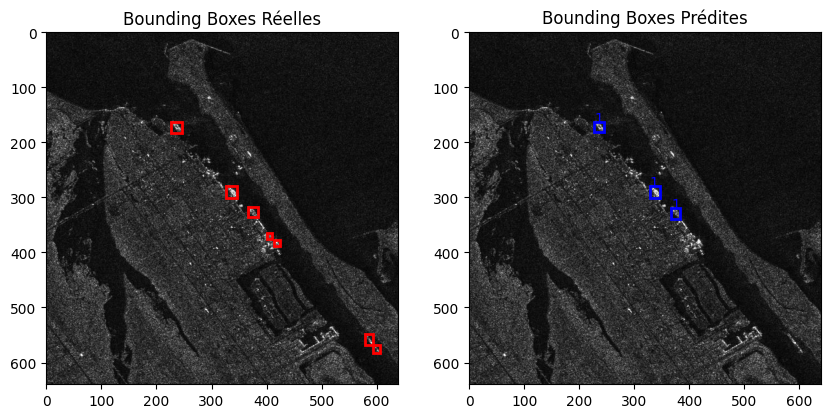

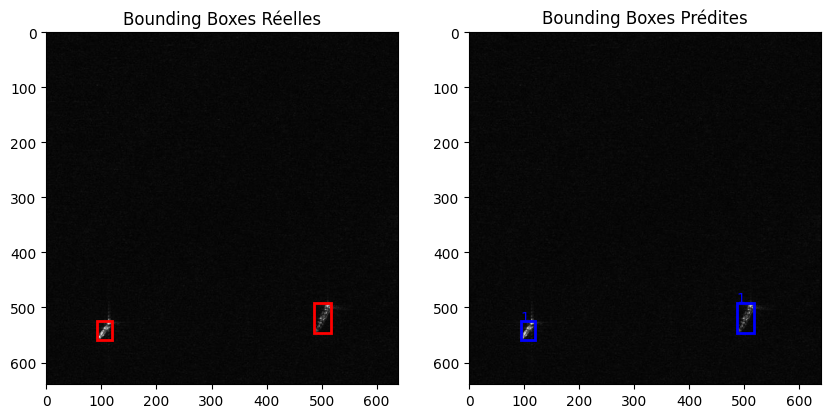

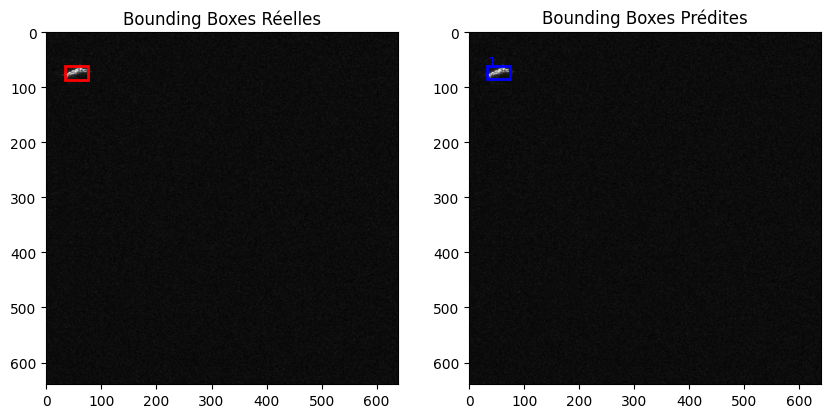

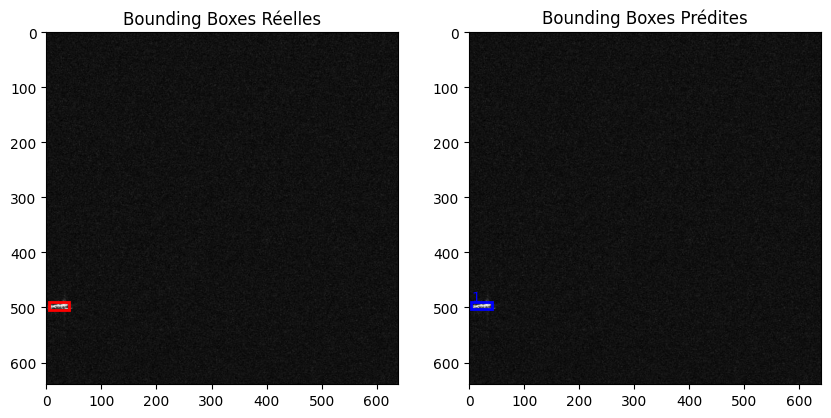

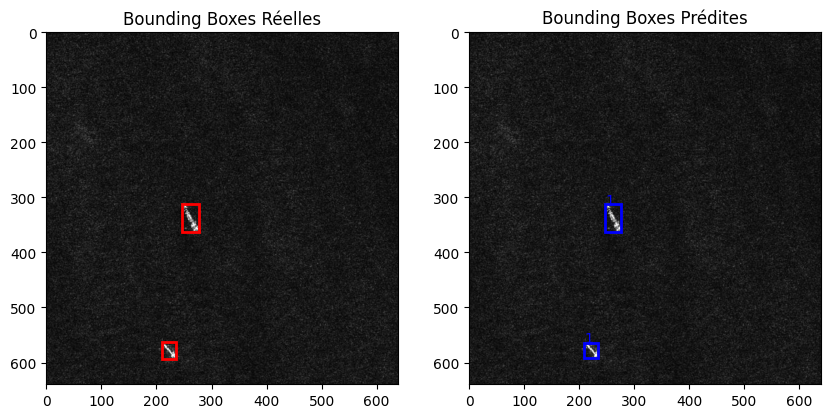

Exception ignored in: <function tqdm.__del__ at 0x000001D1EC879D30>
Traceback (most recent call last):
  File "D:\miniconda3\envs\torchenv\lib\site-packages\tqdm\std.py", line 1148, in __del__
    self.close()
  File "D:\miniconda3\envs\torchenv\lib\site-packages\tqdm\std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
AttributeError: 'tqdm' object has no attribute 'last_print_t'


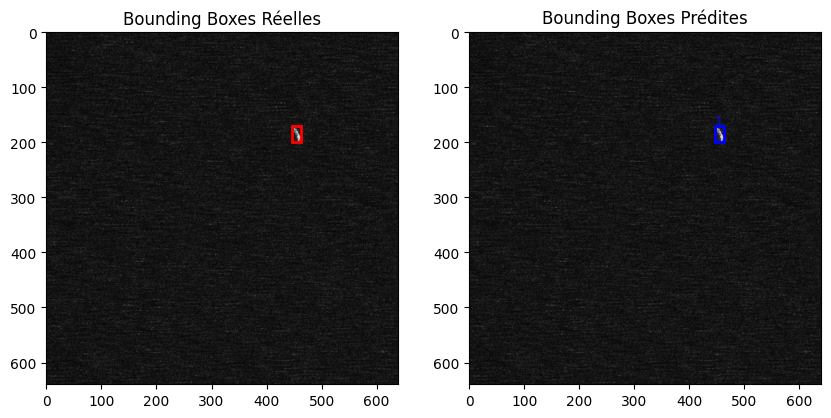

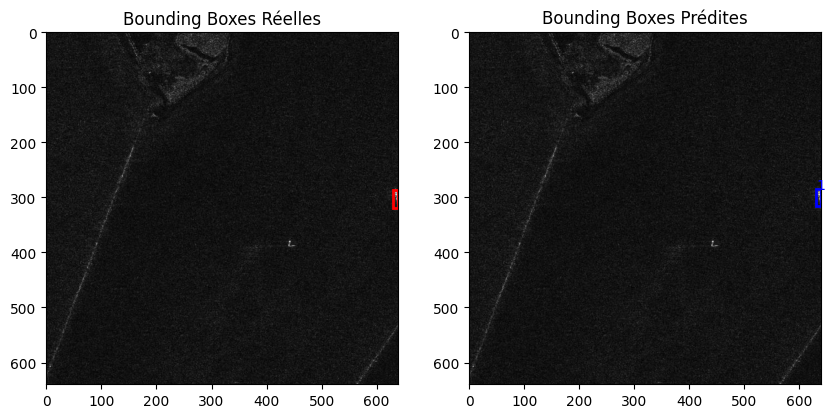

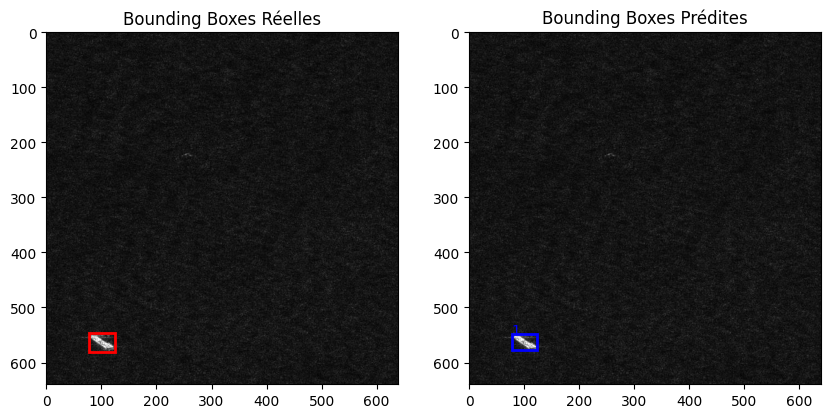

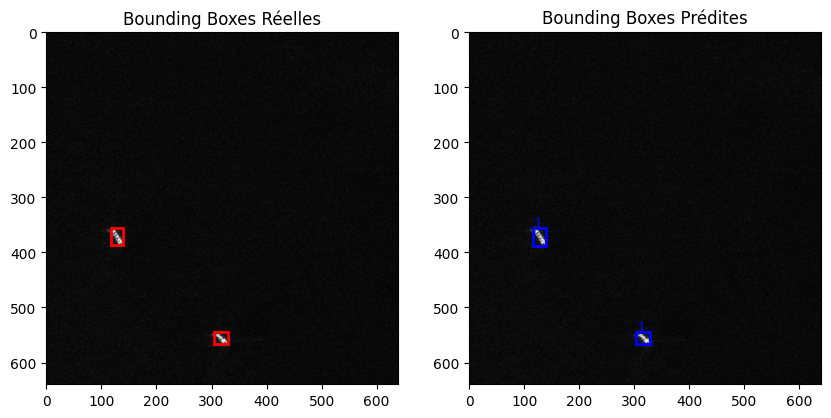

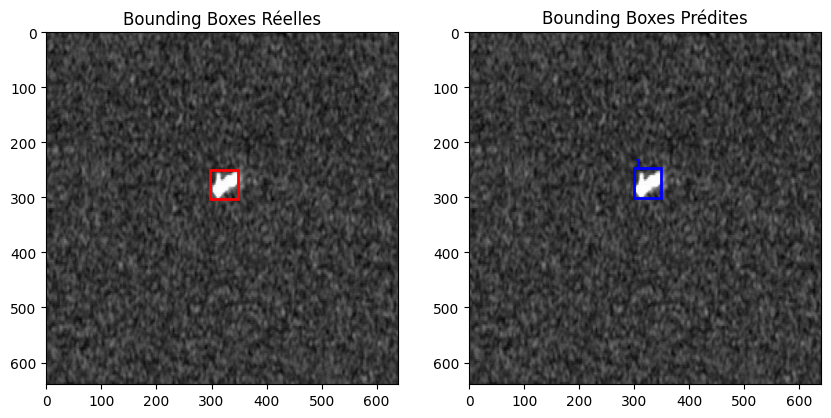

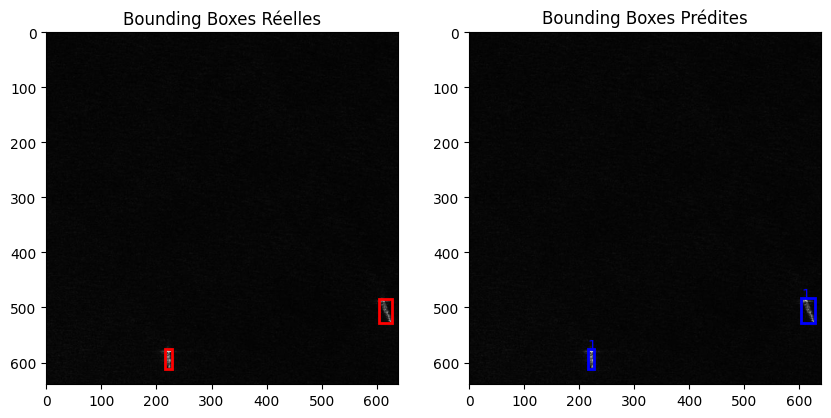

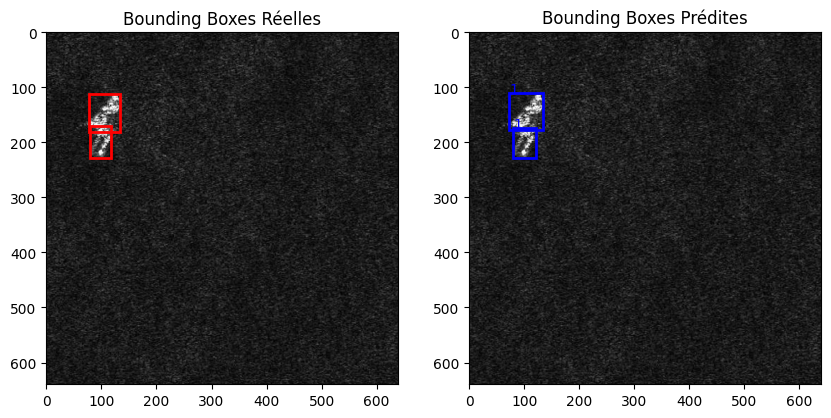

In [63]:
nb_sample = 3
indices = np.random.randint(0, len(real_images), nb_sample)
nb_per_batch = 3

for indice in indices:
    sample_true_bboxes = true_bboxes[indice]
    sample_pred_bboxes = outputs[indice]
    images = real_images[indice]

    for i in range(len(images)):
        curr_image = images[i]
        real_bboxes = sample_true_bboxes[i]
        pred_bboxes = sample_pred_bboxes[i]['boxes'].cpu().numpy()  # Convertir les tenseurs en tableaux numpy
        pred_labels = sample_pred_bboxes[i]['labels'].cpu().numpy() if 'labels' in sample_pred_bboxes[i] else None
        pred_scores = sample_pred_bboxes[i]['scores'].cpu().numpy() if 'scores' in sample_pred_bboxes[i] else None

        plot_image_with_bboxes(curr_image, real_bboxes, pred_bboxes, pred_labels, pred_scores, score_threshold=0.9)

        if i == nb_per_batch:
            break
    